In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from functools import partial

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [5]:
if kharpov:
    true_params = {'theta': 0.50, 
               'pi': -7,
               'phi': -.000001,
               'scale': .1,
               'delta': 1.11,
               'rho': .4,
              }
else:
     true_params ={'delta': 0.27,
                   'rho': 0.81,
                   'scale': 3.11,
                   'phi': -0.000001,
                   'pi': -0.36,
                   'theta': 0.53}
    
time_dim = 1500
sim_dim = 1000
innov_dim = 20

In [6]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [7]:
vl.compute_gamma(**true_params)

9.493119314307742e-07

In [8]:
total_true_params

{'theta': 0.5,
 'pi': -7,
 'phi': -1e-06,
 'scale': 0.1,
 'delta': 1.11,
 'rho': 0.4,
 'gamma': 9.493119314307742e-07,
 'beta': 1.0947020468776714e-05,
 'psi': -2.672612419152287e-06,
 'zeta': 0.999999999999}

In [9]:
true_params

{'theta': 0.5,
 'pi': -7,
 'phi': -1e-06,
 'scale': 0.1,
 'delta': 1.11,
 'rho': 0.4}

In [10]:
total_true_params

{'theta': 0.5,
 'pi': -7,
 'phi': -1e-06,
 'scale': 0.1,
 'delta': 1.11,
 'rho': 0.4,
 'gamma': 9.493119314307742e-07,
 'beta': 1.0947020468776714e-05,
 'psi': -2.672612419152287e-06,
 'zeta': 0.999999999999}

## We start by examining the distributions of simulated data

In [11]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [12]:
omega, omega_cov = vl.estimate_params(data)

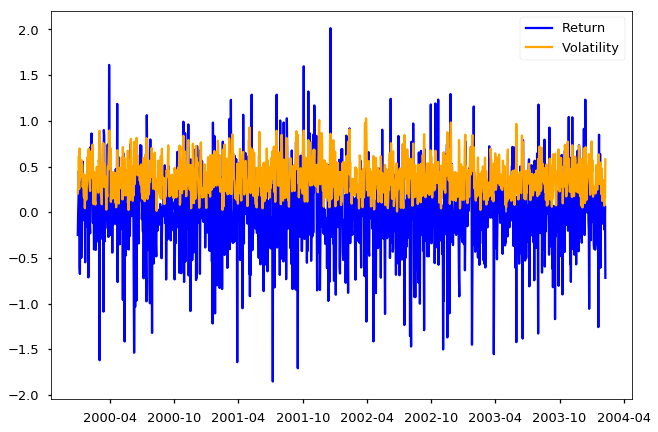

In [13]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [14]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.034565,0.000062
rtn,0.000062,0.189268


In [15]:
total_true_params

{'theta': 0.5,
 'pi': -7,
 'phi': -1e-06,
 'scale': 0.1,
 'delta': 1.11,
 'rho': 0.4,
 'gamma': 9.493119314307742e-07,
 'beta': 1.0947020468776714e-05,
 'psi': -2.672612419152287e-06,
 'zeta': 0.999999999999}

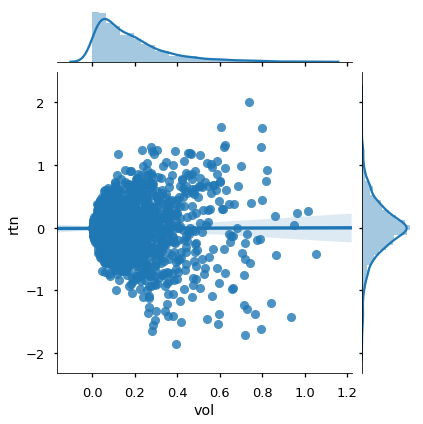

In [16]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [17]:
true_params['delta']

1.11

In [18]:
true_params['scale']

0.1

In [19]:
data.describe()

,vol,rtn
count,1500.000000,1500.000000
mean,0.181718,-0.009310
std,0.167017,0.435049
min,0.000067,-1.853277
25%,0.059296,-0.233209
50%,0.134277,-0.006503
75%,0.248957,0.224689
max,1.054442,2.013635


## I now estimate all of the parameters

In [20]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [21]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [22]:
estimator(data_arr[0])

({'gamma': -0.0025722650297529937,
  'beta': -0.002763482280928525,
  'psi': 0.10638470424865137,
  'zeta': 1.0339574372645657,
  'delta': 1.1916254092473424,
  'rho': 0.3795724784348541,
  'scale': 0.09423300566783936,
  'phi': 0.0,
  'pi': -10.0,
  'theta': 0.0},
            beta     delta     gamma           phi   pi       psi       rho  \
 beta   0.001272  0.000000 -0.000149           NaN  NaN -0.000451  0.000000   
 delta  0.000000  0.004189  0.000000           NaN  NaN  0.000000 -0.000720   
 gamma -0.000149  0.000000  0.000031           NaN  NaN -0.000019  0.000000   
 phi         NaN       NaN       NaN  1.263672e-08  0.0       NaN       NaN   
 pi          NaN       NaN       NaN  0.000000e+00  0.0       NaN       NaN   
 psi   -0.000451  0.000000 -0.000019           NaN  NaN  0.004354  0.000000   
 rho    0.000000 -0.000720  0.000000           NaN  NaN  0.000000  0.000871   
 scale  0.000000 -0.000224  0.000000           NaN  NaN  0.000000 -0.000037   
 theta       NaN       

In [23]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [24]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [25]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

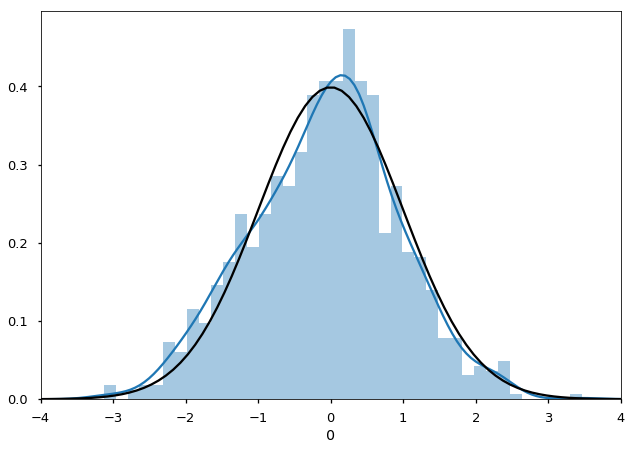

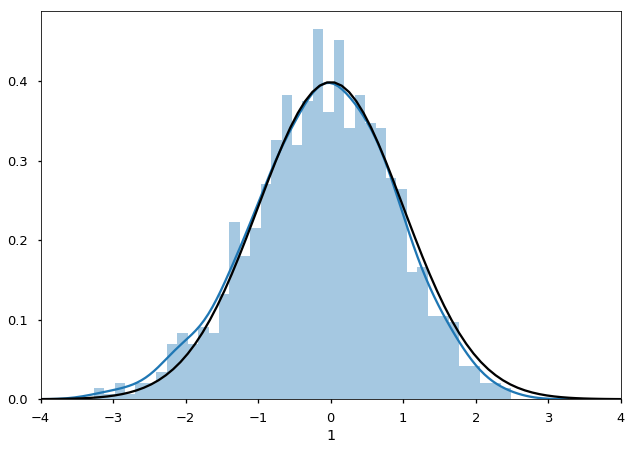

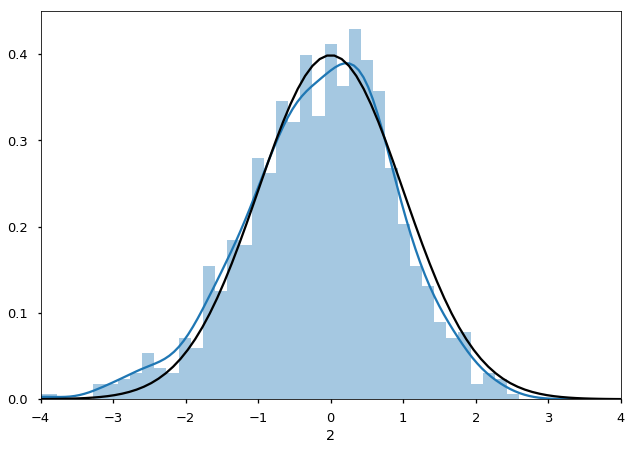

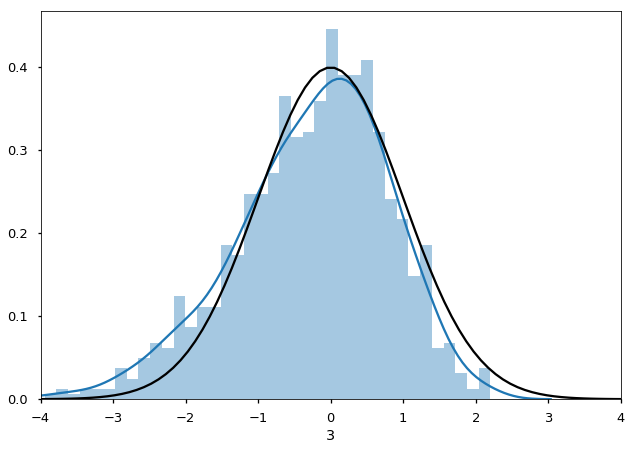

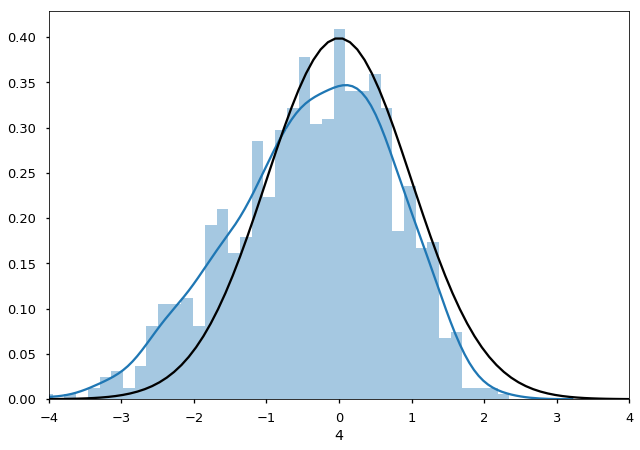

In [26]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

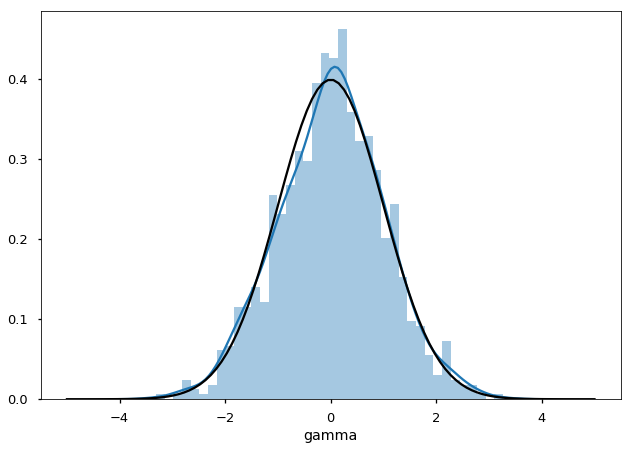

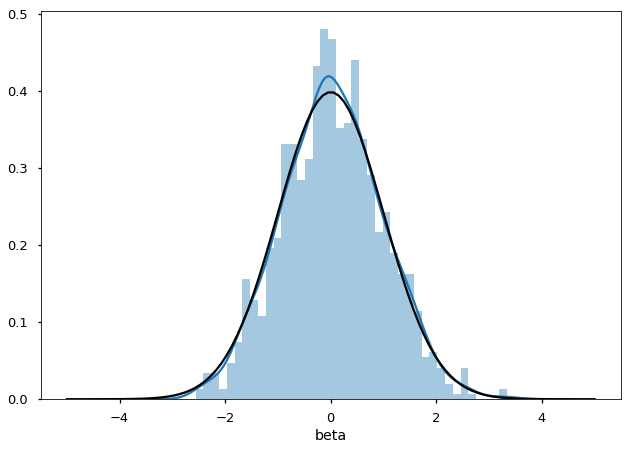

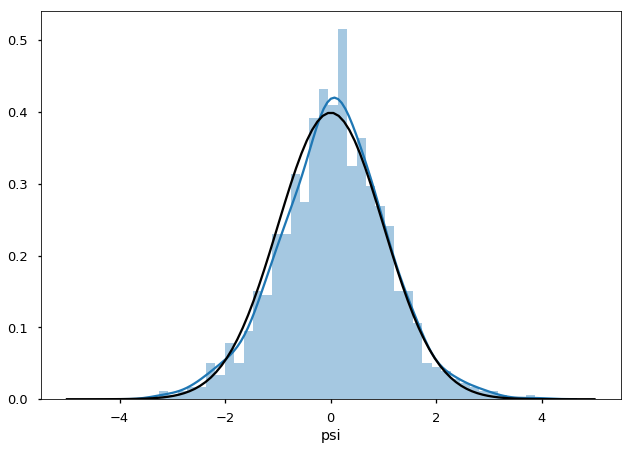

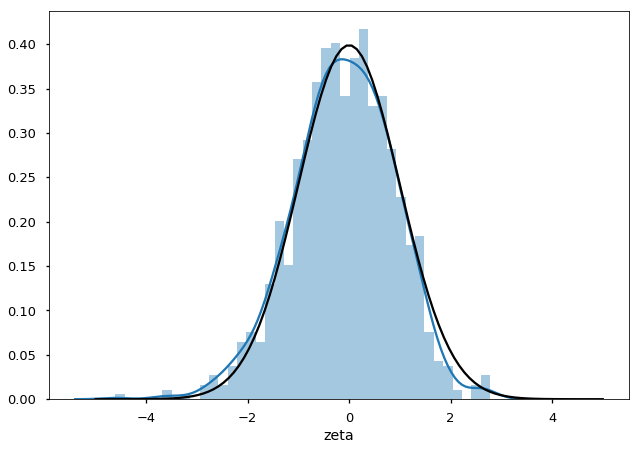

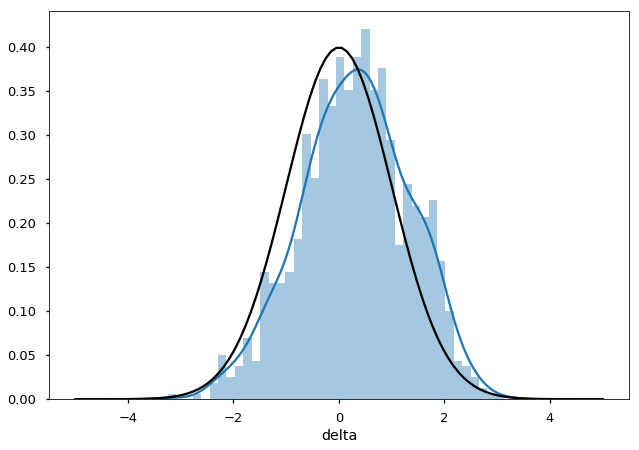

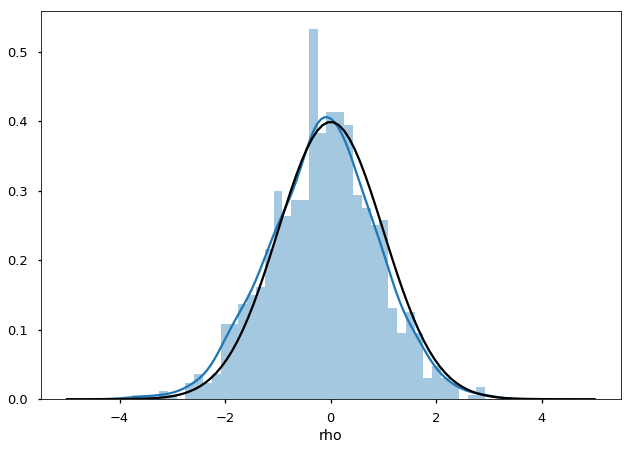

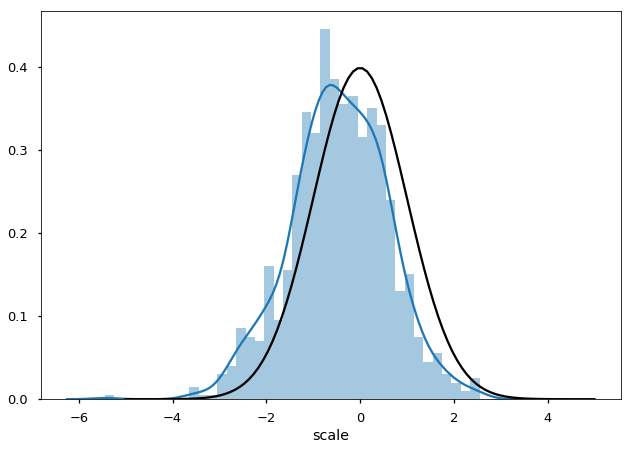

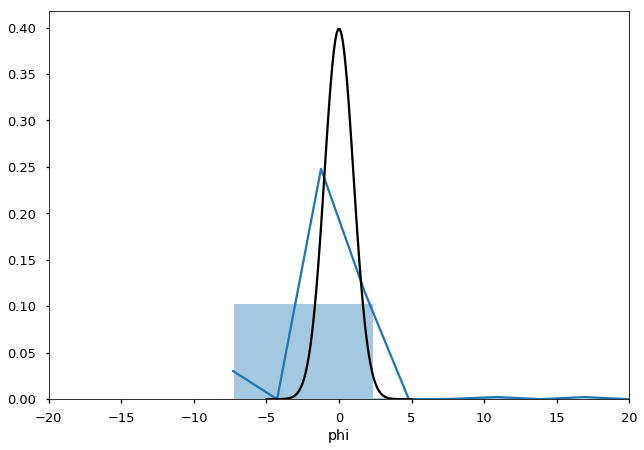

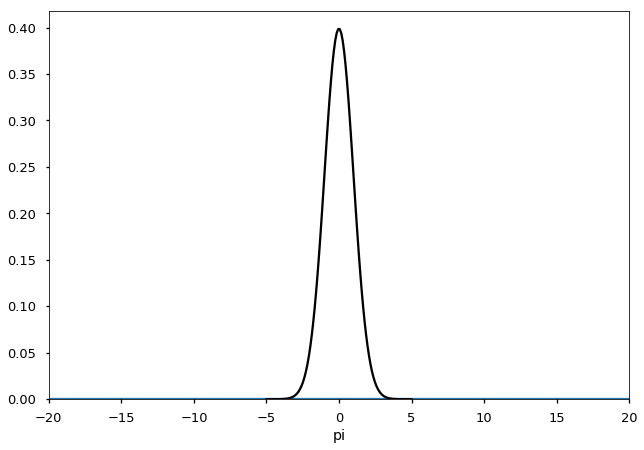

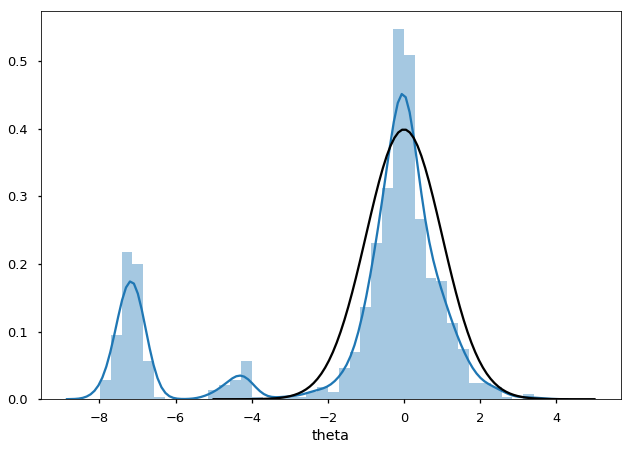

In [27]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

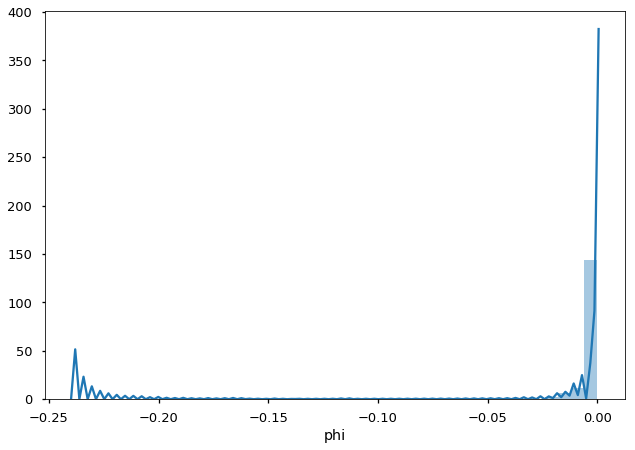

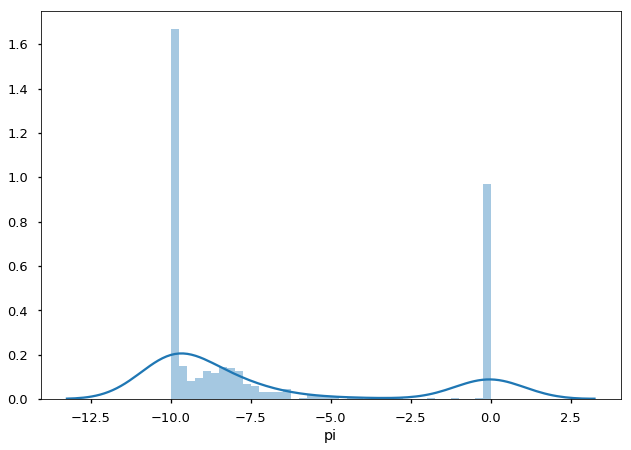

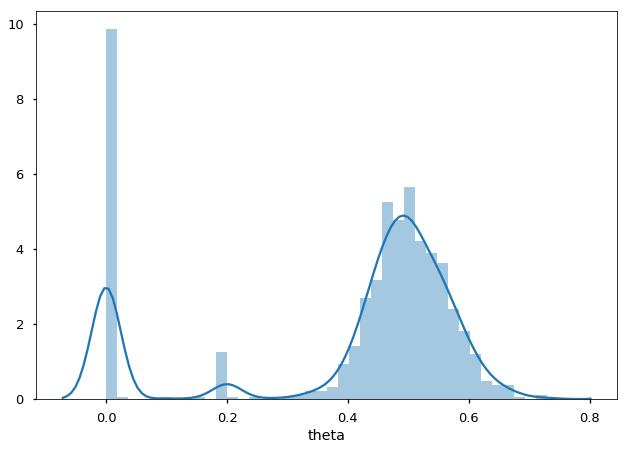

In [28]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

# I now compute the robust conditional QLR statistic 

In [29]:
omega


{'gamma': -0.012404800312697976,
 'beta': 0.03669664954890446,
 'psi': -0.018755136786527977,
 'zeta': 1.043291744888267,
 'delta': 1.1805741222951198,
 'rho': 0.38653454756440553,
 'scale': 0.09448041009262727}

In [30]:
true_params

{'theta': 0.5,
 'pi': -7,
 'phi': -1e-06,
 'scale': 0.1,
 'delta': 1.11,
 'rho': 0.4}

In [31]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], true_params['theta']],
                      innov_dim=10, alpha=None, robust_quantile=True)

In [ ]:
total=min(100, len(est_arr))
with Pool(8) as pool:
    results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
                                                                                    est_arr[:total]),
                                                          total=total))))

In [ ]:
results.head()

In [ ]:
robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
                                    reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
fig, ax = mpl.pyplot.subplots()
cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='standard')
cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='robust')
ax.legend()
fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr[:500], true_params, innov_dim=10, alpha=0.05, case=1,
                                        robust_quantile=True)

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
else:
    filename = '../results/reject_prop_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
    
returnval.to_json(filename)

In [ ]:
returnval.head()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.robust_qlr_qauntile, kde_kws={"color": "red", "lw": 3, 'cumulative':True},
                 ax=ax4,hist=False, label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)